<a href="https://colab.research.google.com/github/iborgstedt2848/ML_G84_G2_P2/blob/main/segunda_pr%C3%A1ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segunda Práctica

**Autores:**

---


Luis Enrique Valero Montero - Gr. 85 - 100495982

Isabelle Borgstedt - Gr. 84 - 100559990

# Scalers

Primero, vamos a visualizar los diferentes scalers: MinMaxScaler, StandardScaler, y RobustScaler usando gráficos que muestran los clusters. Después, podemos elegir el mejor basado en las métricas y los gráficos.

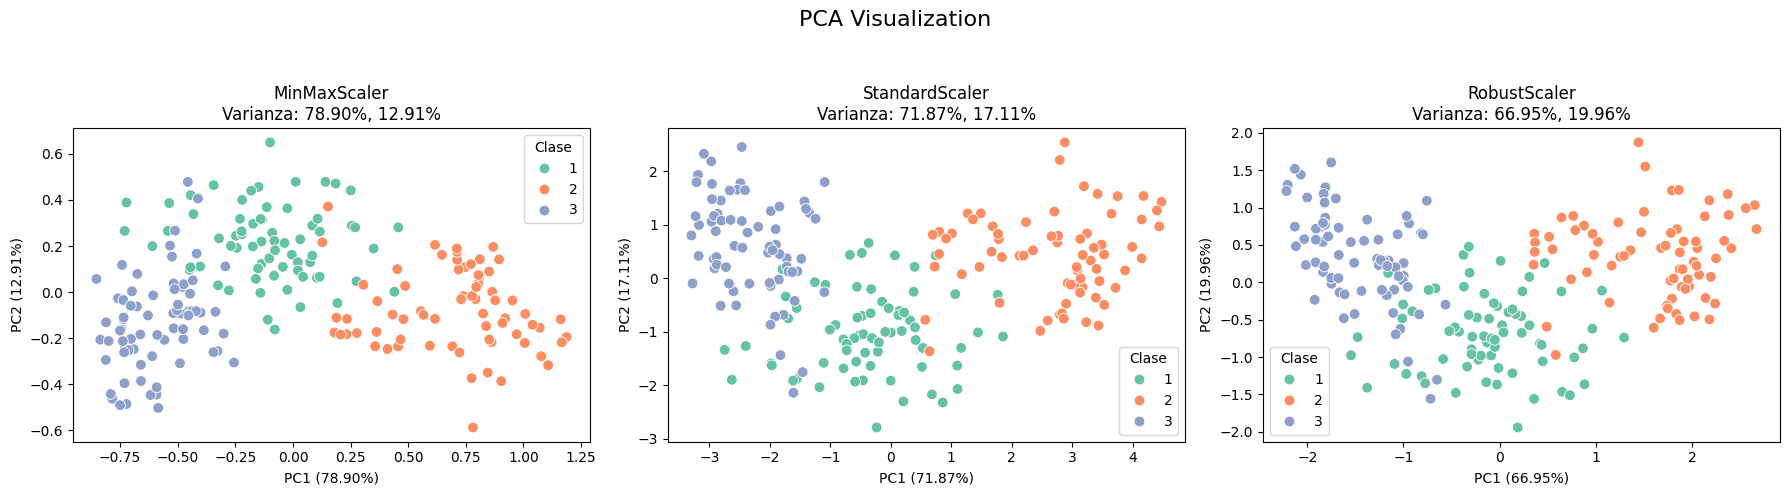

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# cargar los datos
df = pd.read_csv("semillas.csv")
X = df.drop(columns=['clase'])
y = df['clase']

# semilla para la reproducibilidad
random_seed = 559990

# dictionario de scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('PCA Visualization', fontsize=16)

# probar cada scaler y realizar PCA
for ax, (name, scaler) in zip(axes, scalers.items()):
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=random_seed))
    ])

    X_pca = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['class'] = y

    sns.scatterplot(
        data=pca_df,
        x='PC1', y='PC2',
        hue='class',
        palette='Set2',
        ax=ax,
        s=60
    )

    ax.set_title(f"{name}\nVarianza: {explained_variance[0]:.2%}, {explained_variance[1]:.2%}")
    ax.set_xlabel(f"PC1 ({explained_variance[0]:.2%})")
    ax.set_ylabel(f"PC2 ({explained_variance[1]:.2%})")
    ax.legend().set_title('Clase')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


También podemos calcular la efectivdad de cada scaler con las métricas Silhouette Score, Davies-Bounldin Index, y Calinski Harabasz score para obtener una respuesta más objetiva del rendimiento de los scalers.

In [3]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

results = []

for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=random_seed))
    ])

    X_scaled_pca = pipeline.fit_transform(X)

    # correr kmeans con k=3
    kmeans = KMeans(n_clusters=3, random_state=random_seed)
    labels = kmeans.fit_predict(X_scaled_pca)

    # evaluar las métricas
    silhouette = silhouette_score(X_scaled_pca, labels)
    db_index = davies_bouldin_score(X_scaled_pca, labels)
    ch_index = calinski_harabasz_score(X_scaled_pca, labels)

    results.append({
        'Scaler': name,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Calinski-Harabasz Index': ch_index
    })

# convertirse en df
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Silhouette Score', ascending=False))


           Scaler  Silhouette Score  Davies-Bouldin Index  \
0    MinMaxScaler          0.503160              0.697186   
1  StandardScaler          0.493430              0.706673   
2    RobustScaler          0.489777              0.699397   

   Calinski-Harabasz Index  
0               464.844797  
1               397.301078  
2               360.897259  


Silhouette Score: Mide qué tan bien se ajusta un punto a su propio clúster en comparación con otros clusters. Los valores cercanos a 1 indican un mejor agrupamiento.

Davies-Bouldin Index: Mide la similitud promedio entre cada cluster y el cluster más similar. Cuanto menor sea el valor, mejor.

Calinski-Harabasz Index: Relación entre la dispersión entre clusters y la dispersión interna de los clusters. Cuanto mayor sea el valor, mejor.

Todos las métricas muestran que MinMaxScaler es el mejor porque tiene el Silhouette Score más alto, el Davies-Bouldin Index más bajo, t el Calinski-Harabasz Index más alto.

# K-Means

Vamos a usar K-Means para agrupar los datos en clusters. Vamos a determinar cuántos clusters son necesarios para obtener un buen resultado usando clusters con codo y silueta.

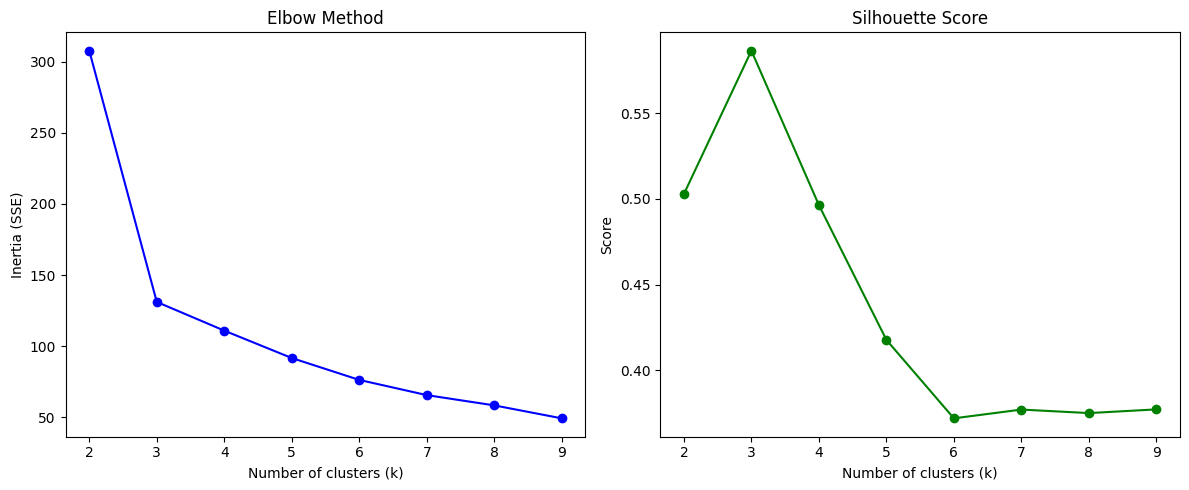

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_df, kmeans.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'go-')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

Para clusters con codo, graficamos el número de clusters contra la inercia (SSE) que es una medida de la compacidad de los puntos de datos con respecto al centroide. Estamos buscando el "codo" del gráfico porque esto es el punto en lo que el reducción de SSE comienza a estabilizarse.

Para clusters con silueta, graficamos el número de clusters contra la puntuación que es una medida del ajuste de cada punto en su cluster (en comparación con otros clusteres). Estamos buscando números más grades, más cercos a uno.

Está claro que k_best = 3 según los dos.

In [9]:
k_best = 3
kmeans = KMeans(n_clusters=k_best, random_state=42)
kmeans.fit(pca_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_


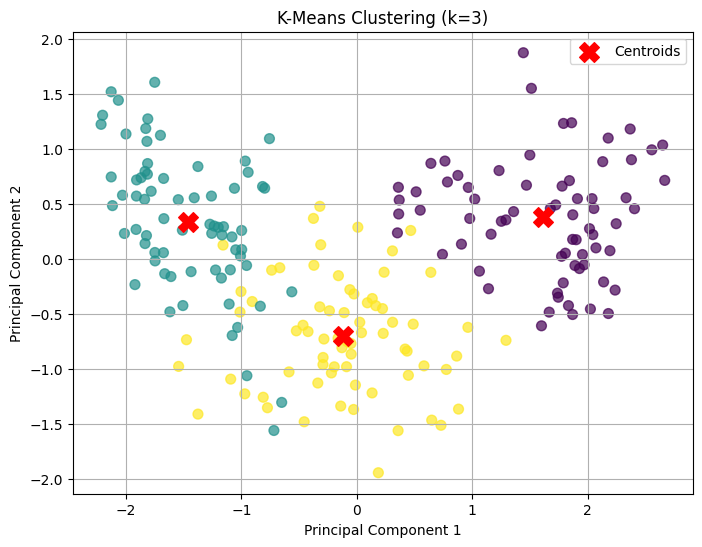

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title(f'K-Means Clustering (k={k_best})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


# Hierarchical Clustering/Dendrograms

Entonces vamosa a usar Hierarchical Clustering/Dendrograms para agrupar los datos en clusters. Vamos a determinar cuántos clusters son necesarios para obtener un buen resultado usando funciones de linkage.

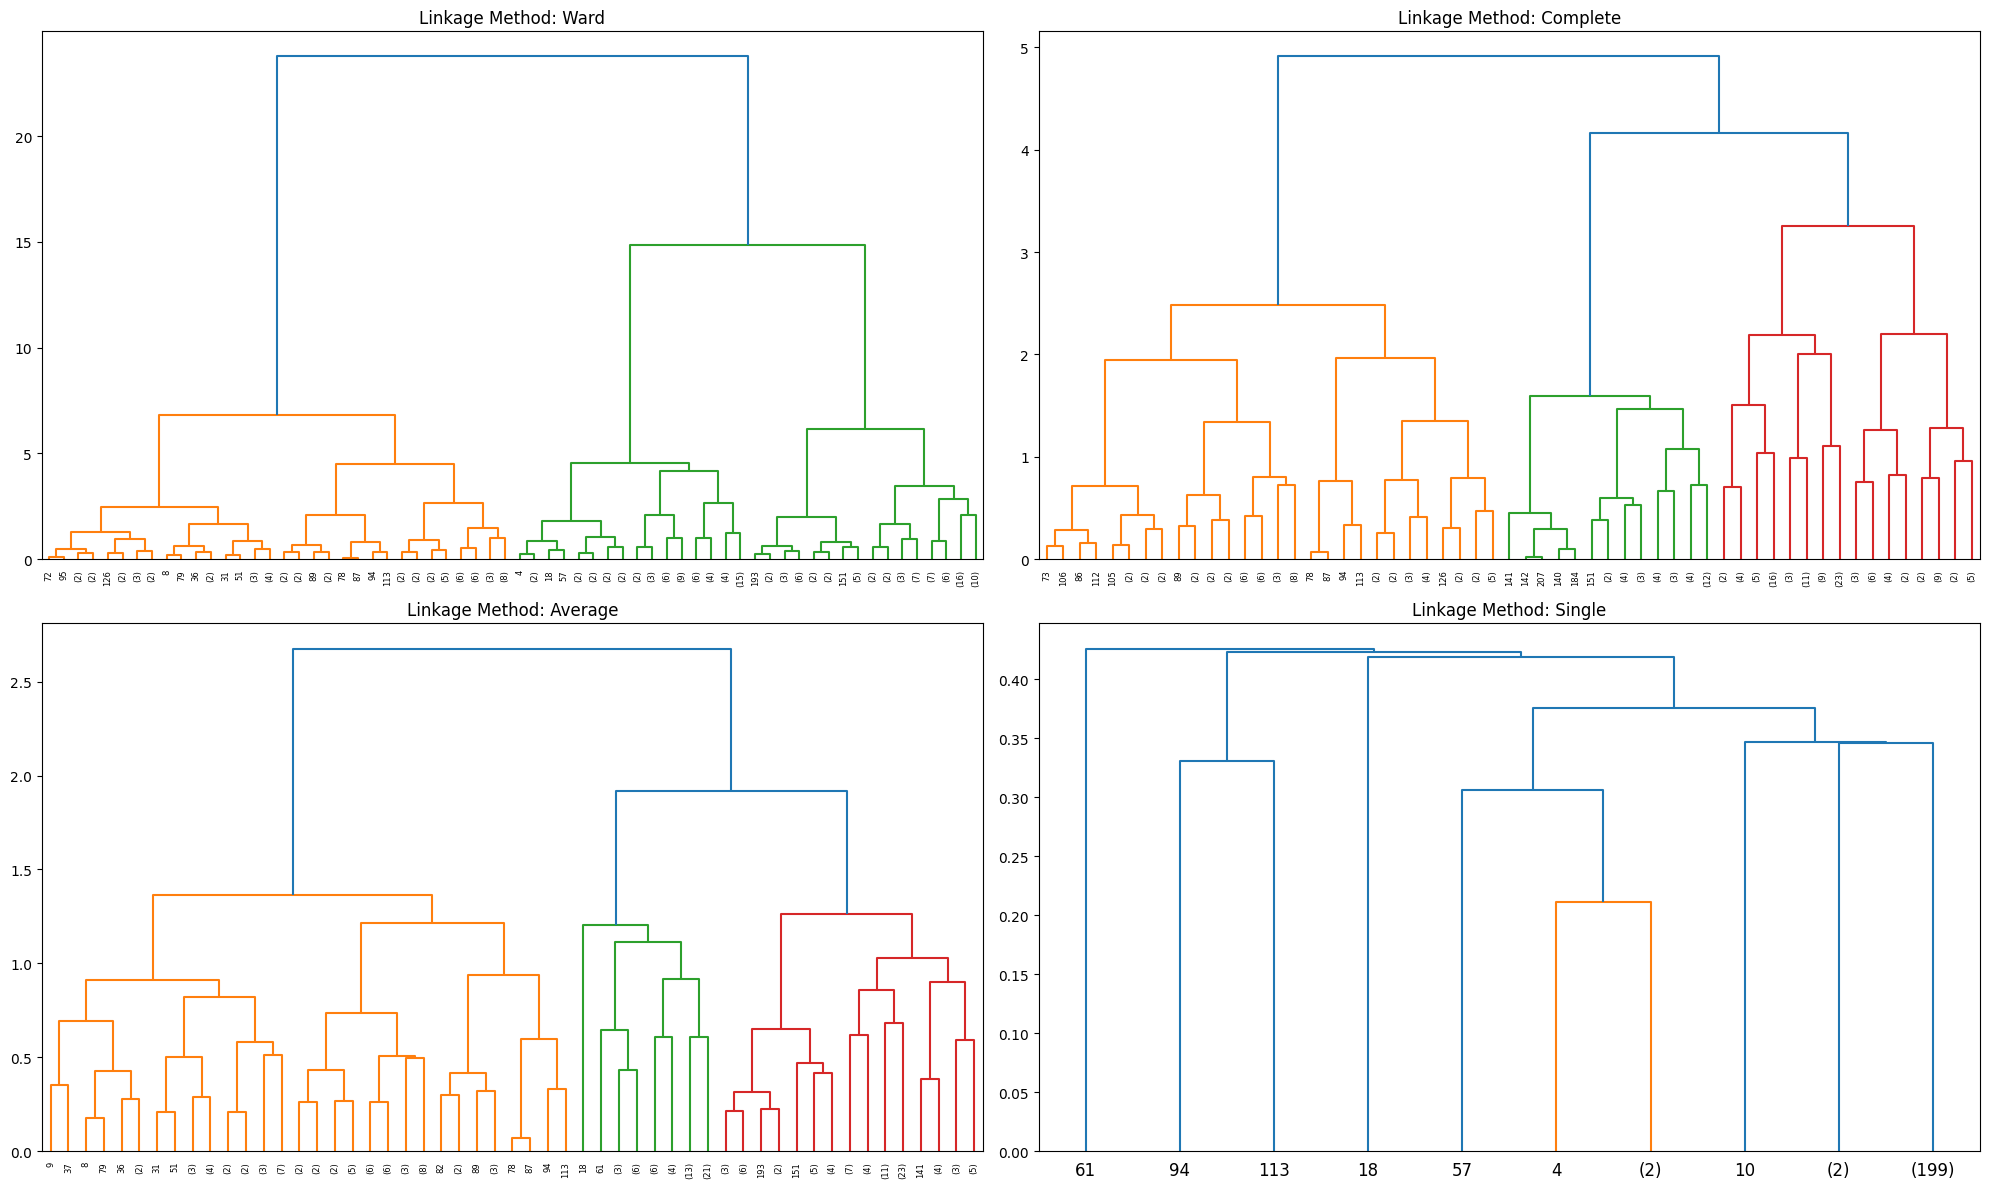

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

linkage_methods = ['ward', 'complete', 'average', 'single']

#dendrograms
plt.figure(figsize=(20, 12))
for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)
    Z = linkage(pca_df[['PC1', 'PC2']], method=method)
    dendrogram(Z, truncate_mode='level', p=5)
    plt.title(f'Linkage Method: {method.capitalize()}')

plt.tight_layout()
plt.show()

Está claro que Ward es el mejor función de linkeage porque es el más simétrico. Ward reduce la varianza y a menudo su rendimiento es similar a K-Means.

También podemos ver que Ward crea 3 clusters. Hay un hueco vertical entre el nivel 3 y el nivel 2 que signifca que 3 es el mejor. El uso de 2 clusters combinaría clusters con demasiada separación.

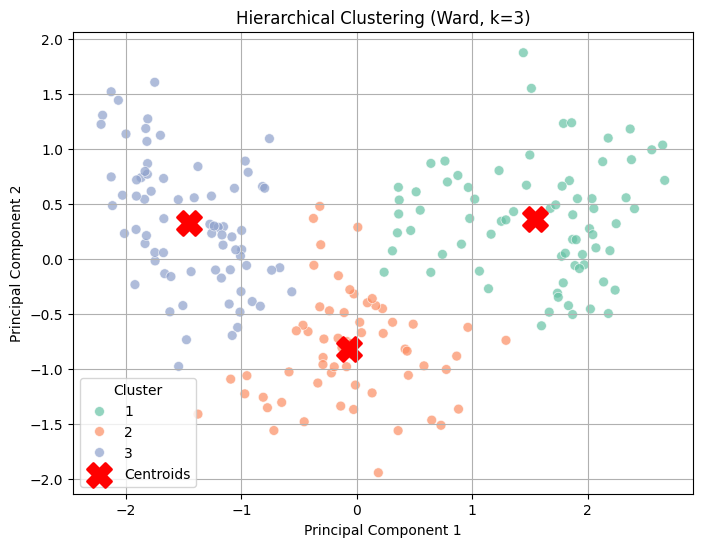

In [19]:
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# realizar clustering
Z = linkage(pca_df[['PC1', 'PC2']], method='ward')
clusters = fcluster(Z, t=3, criterion='maxclust')

# calcular centroids
centroids = np.array([pca_df[clusters == i][['PC1', 'PC2']].mean(axis=0) for i in range(1, 4)])

plt.figure(figsize=(8, 6))

sns.scatterplot(x='PC1', y='PC2', hue=clusters, palette='Set2', data=pca_df, s=50, alpha=0.7)

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, marker='X', label='Centroids', linewidth=2)

plt.title('Hierarchical Clustering (Ward, k=3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# DBSCAN

# Análisis

In [21]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# establecer número de clusters = 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_df)

# hierarchical clustering: n_clusters = 3 y ward
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels = hc.fit_predict(pca_df)

def evaluate_clustering(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    print(f"{name} Clustering:")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Davies–Bouldin Index: {db:.3f}")
    print(f"Calinski–Harabasz Score: {ch:.3f}")
    print("-" * 40)

evaluate_clustering(pca_df, kmeans_labels, "K-Means")
evaluate_clustering(pca_df, hierarchical_labels, "Hierarchical")


K-Means Clustering:
Silhouette Score: 0.598
Davies–Bouldin Index: 0.589
Calinski–Harabasz Score: 467.487
----------------------------------------
Hierarchical Clustering:
Silhouette Score: 0.596
Davies–Bouldin Index: 0.581
Calinski–Harabasz Score: 459.273
----------------------------------------


Según esta comparación, el rendimiento de K-Means es un poco mejor que el rendimiento de Hierarchical clustering porque K-Means tiene un Davies-Bouldin Index más pequeño y un Calinski-Harabasz Score más grande.